<a href="https://colab.research.google.com/github/VictorFrancheto/Complex_Network/blob/main/lista_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Instalando a biblioteca `graph-tool`(https://graph-tool.skewed.de)


In [1]:
!mkdir -p /etc/apt/keyrings; mkdir -p ~/.gnupg; chmod 700 ~/.gnupg
!gpg --no-default-keyring --keyring /etc/apt/keyrings/skewed.de.gpg --keyserver keyserver.ubuntu.com --recv-keys 612DEFB798507F25
!echo "deb [signed-by=/etc/apt/keyrings/skewed.de.gpg] https://downloads.skewed.de/apt $(lsb_release -s -c) main" > /etc/apt/sources.list.d/skewed.list
!apt-get update
!apt-get install python3-graph-tool python3-matplotlib python3-cairo

gpg: keybox '/etc/apt/keyrings/skewed.de.gpg' created
gpg: /root/.gnupg/trustdb.gpg: trustdb created
gpg: key 612DEFB798507F25: public key "Tiago de Paula Peixoto <tiago@skewed.de>" imported
gpg: Total number processed: 1
gpg:               imported: 1
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Ign:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Get:8 https://r2u.stat.illinois.edu/ubuntu jammy Release [5,713 B]
Get:9 https://r2u.stat.illinois.edu/ubuntu jammy Release.gpg [793 B]
Get:10 https://downloads.skewed.de/apt jammy InRelease [7,536 B]
Get:11 http://archive.ubuntu.com/ubuntu jamm

In [2]:
# O Colab usa uma instalação Python diferente da do sistema! Colaboração ruim! Precisamos de algumas soluções alternativas.
!apt purge python3-cairo
!apt install libcairo2-dev pkg-config python3-dev
!pip install --force-reinstall pycairo
!pip install zstandard

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following packages will be REMOVED:
  python3-cairo*
0 upgraded, 0 newly installed, 1 to remove and 49 not upgraded.
After this operation, 310 kB disk space will be freed.
(Reading database ... 132001 files and directories currently installed.)
Removing python3-cairo:amd64 (1.20.1-3build1) ...
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-dev is already the newest version (3.10.6-1~22.04.1).
python3-dev set to manually installed.
The following packages were automatically installed and are no longer required:
  libbz2-dev libpkgconf3 libreadline-dev
Use 'apt autoremove' to remove them.
The following additional packages will be installed:
  libblkid-dev libblkid1 libcairo-script-interpreter2 libffi-dev libglib2.0-dev libglib2.0-dev-bin
  libice-dev liblzo2-2 libmount-dev libmount1 libpixman-1-dev libselinux1-dev libsepol-dev
  lib

### Agora podemos usar a ferramenta gráfica como qualquer outro módulo Python

In [3]:
import graph_tool.all as gt

# Redes Complexas
---

Redes selecionadas:

https://networks.skewed.de/net/jazz_collab

**Descrição:**
A rede de colaborações entre músicos de jazz e entre bandas de jazz, extraída do banco de dados digital The Red Hot Jazz Archive, abrange bandas que se apresentaram entre 1912 e 1940.

**Citação:** P. Gleiser and L. Danon, "Community Structure in Jazz." Advances in Complex Systems 6(4), 565-573 (2003)., https://doi.org/10.1142/S0219525903001067 [@sci-hub]

----

https://networks.skewed.de/net/facebook_organizations

**Descrição:** Redes de amizades entre usuários do Facebook que indicaram emprego em uma das corporações-alvo. As empresas variam em tamanho, de pequenas a grandes. Em cada instantâneo, apenas as conexões entre funcionários da mesma empresa são incluídas.

**Citação:**
M. Fire, and R. Puzis, "Organization mining using online social networks." Networks and Spatial Economics 16(2), 545-578 (2016), https://arxiv.org/abs/1303.3741



### Importando bibliotecas

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import spearmanr

#### Lendo as redes selecionadas

In [5]:
def process_graph(graph_name, directed=True):
    """
    Processa um grafo da coleção Graph-tool, convertendo-o para um grafo NetworkX,
    removendo auto-laços e imprimindo o número de nós e arestas.

    Parâmetros:
    graph_name (str): Nome do grafo na coleção Graph-tool.
    directed (bool): Se True, cria um grafo direcionado; se False, cria um grafo não direcionado.
    """
    # Carregar o grafo do graph-tool
    G_gt = gt.collection.ns[graph_name]

    # Criar um grafo vazio do NetworkX, direcionado ou não
    G_nx = nx.DiGraph() if directed else nx.Graph()

    # Adicionar arestas do grafo do Graph-tool para o grafo do NetworkX
    for edge in G_gt.edges():
        G_nx.add_edge(edge.source(), edge.target())

    # Remover auto-laços
    G_nx.remove_edges_from(nx.selfloop_edges(G_nx))

    # Imprimir o número de nós e arestas
    print(f"Grafo: {graph_name}")
    print("Número de nós:", G_nx.number_of_nodes())
    print("Número de arestas:", G_nx.number_of_edges())

    return G_nx  # Retorna o grafo processado

# Processar os grafos direcionados
G_jazz = process_graph("jazz_collab", directed=False)
G_facebook = process_graph("facebook_organizations/S1", directed=False)


Grafo: jazz_collab
Número de nós: 198
Número de arestas: 2742
Grafo: facebook_organizations/S1
Número de nós: 320
Número de arestas: 2369


#### Plotando as redes

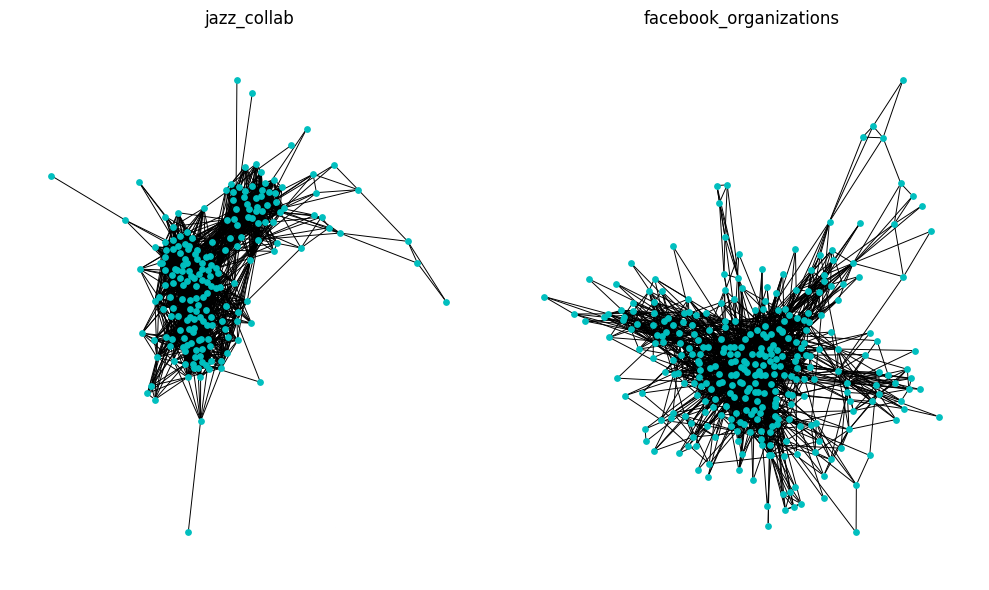

In [6]:
def plot_graph(G_nx, ax, title):
    """
    Função para plotar um grafo em um eixo específico.

    Parâmetros:
    G_nx (networkx.Graph): O grafo a ser plotado.
    ax (matplotlib.Axes): O eixo onde o grafo será plotado.
    title (str): O título do grafo.
    """
    pos = nx.spring_layout(G_nx)  # Definir a disposição do grafo
    nx.draw(
        G_nx, pos,
        ax=ax,
        with_labels=False,  # Sem rótulos
        node_color='c',  # Nós na cor azul claro
        edge_color='black',  # Arestas na cor preta
        node_size=15,
        width=0.7,
        font_size=5,
        font_weight='bold',
        arrows=True  # Exibir setas
    )
    ax.set_title(title)  # Título do subplot

# Criar uma figura com subplots 1x2
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plotar os grafos nos subplots
plot_graph(G_jazz, axes[0], "jazz_collab")
plot_graph(G_facebook, axes[1], "facebook_organizations")

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()


**Exercício 1.**  Considere uma das medidas de similaridade estrutural. Mostre a distribuição de similaridade entre todos os pares de vértices (histograma dos valores de similares considerando todos os pares de vértices).

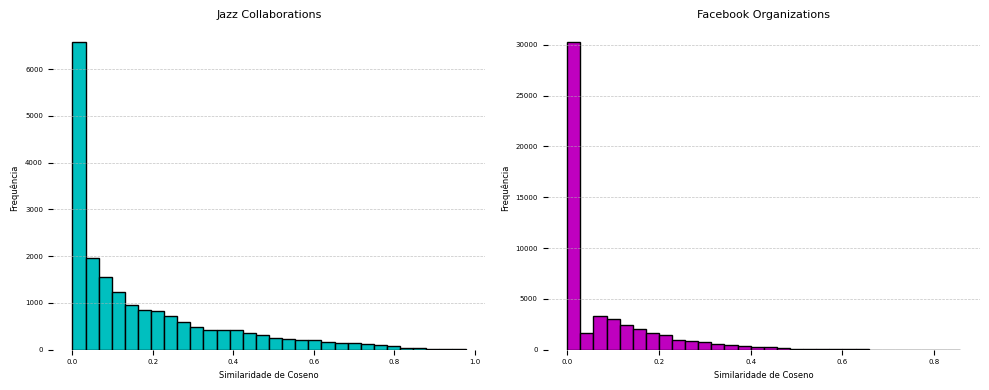

In [22]:
def calculate_cosine_similarity_nx(G_nx):
    """
    Calcula a similaridade de coseno para todos os pares de nós no grafo usando NetworkX.

    Parâmetros:
    G_nx (networkx.Graph): O grafo para o qual calcular a similaridade.

    Retorna:
    list: Lista de similaridades de coseno para todos os pares de vértices.
    """
    # Obter a matriz de adjacência do grafo
    adjacency_matrix = nx.to_numpy_array(G_nx)

    # Calcular a similaridade de coseno
    cosine_sim = cosine_similarity(adjacency_matrix)

    # Extrair os valores de similaridade sem considerar a diagonal
    similarities = []
    for i in range(len(cosine_sim)):
        for j in range(i + 1, len(cosine_sim)):
            similarities.append(cosine_sim[i][j])

    return similarities

# Calcular a similaridade de coseno para os grafos
similarities_jazz = calculate_cosine_similarity_nx(G_jazz)
similarities_facebook = calculate_cosine_similarity_nx(G_facebook)

# Criar uma figura com subplots 1x2, ajustando o tamanho
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Plotar o histograma das similaridades de coseno para G_jazz
axes[0].hist(similarities_jazz, bins=30, color='c', edgecolor='black')
axes[0].set_title('Jazz Collaborations', fontsize=8)  # Título menor
axes[0].set_xlabel('Similaridade de Coseno', fontsize=6)
axes[0].set_ylabel('Frequência', fontsize=6)
axes[0].tick_params(axis='both', which='major', labelsize=5)
axes[0].grid(axis='y', alpha=0.75)

# Remover as linhas de fundo (spines) e a grade paralela ao eixo x
axes[0].spines['top'].set_visible(False)
axes[0].spines['right'].set_visible(False)
axes[0].spines['left'].set_visible(False)
axes[0].spines['bottom'].set_visible(False)
axes[0].grid(axis='y', linestyle='--', linewidth=0.5)  # Linhas horizontais suaves
axes[0].grid(axis='x', visible=False)  # Desativar linhas paralelas ao eixo x

# Plotar o histograma das similaridades de coseno para G_facebook
axes[1].hist(similarities_facebook, bins=30, color='m', edgecolor='black')
axes[1].set_title('Facebook Organizations', fontsize=8)  # Título menor
axes[1].set_xlabel('Similaridade de Coseno', fontsize=6)
axes[1].set_ylabel('Frequência', fontsize=6)
axes[1].tick_params(axis='both', which='major', labelsize=5)
axes[1].grid(axis='y', alpha=0.75)

# Remover as linhas de fundo (spines) e a grade paralela ao eixo x
axes[1].spines['top'].set_visible(False)
axes[1].spines['right'].set_visible(False)
axes[1].spines['left'].set_visible(False)
axes[1].spines['bottom'].set_visible(False)
axes[1].grid(axis='y', linestyle='--', linewidth=0.5)  # Linhas horizontais suaves
axes[1].grid(axis='x', visible=False)  # Desativar linhas paralelas ao eixo x

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()


**Exercício 2.** A similaridade estrutural é baseada no número de vizinhos compartilhados. Esta medida também pode ser vista como o número de caminhos de comprimento 2 entre os vértices sendo comparados. Repita o exercício 1, calculando o número de caminhos de comprimento 3, 4 e 5. Discuta como a distribuição se modifica.

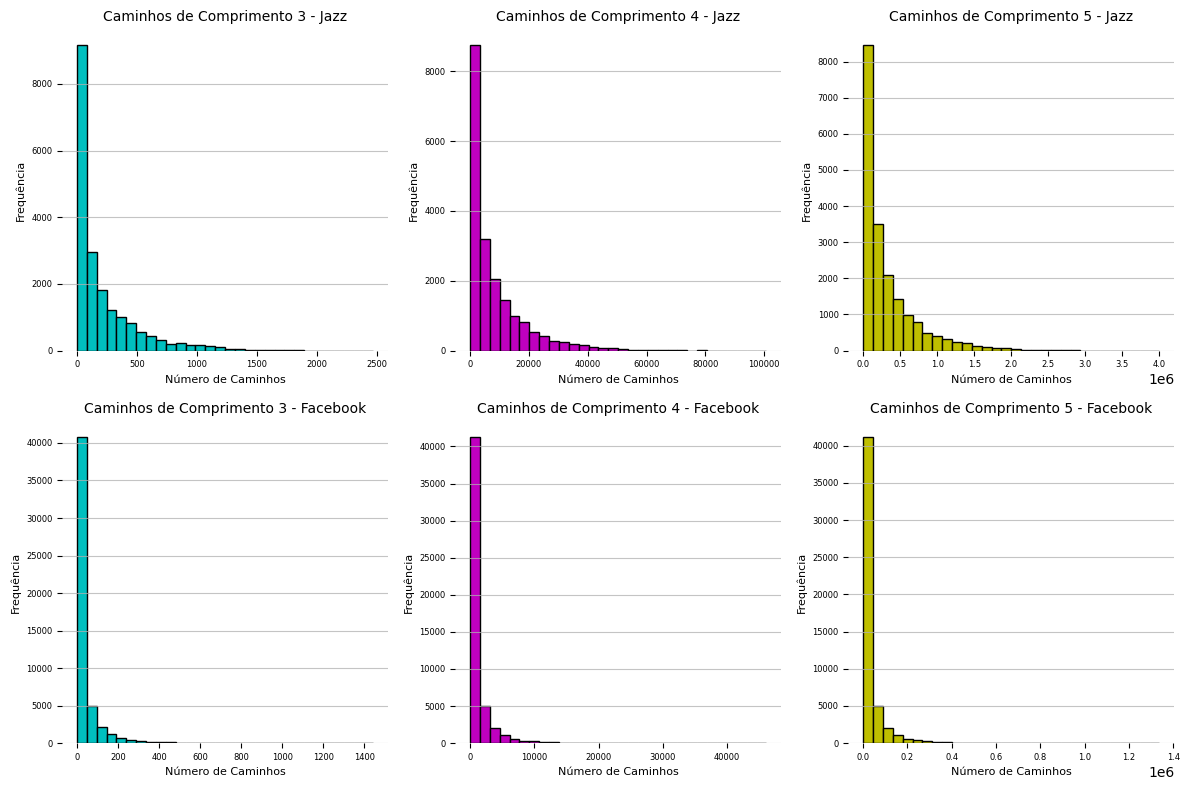

In [18]:
def count_paths_of_length_k(G_nx, k):
    """
    Conta o número de caminhos de comprimento k entre todos os pares de nós no grafo.

    Parâmetros:
    G_nx (networkx.Graph): O grafo no qual contar os caminhos.
    k (int): O comprimento dos caminhos a serem contados.

    Retorna:
    list: Lista do número de caminhos de comprimento k para todos os pares de vértices.
    """
    # Obter a matriz de adjacência do grafo
    adjacency_matrix = nx.to_numpy_array(G_nx)

    # Elevar a matriz de adjacência à potência k
    paths_matrix = np.linalg.matrix_power(adjacency_matrix, k)

    # Extrair os valores de caminhos sem considerar a diagonal
    path_counts = []
    for i in range(len(paths_matrix)):
        for j in range(i + 1, len(paths_matrix)):
            path_counts.append(paths_matrix[i][j])

    return path_counts

# Calcular o número de caminhos de diferentes comprimentos para os grafos
paths_3_jazz = count_paths_of_length_k(G_jazz, 3)
paths_4_jazz = count_paths_of_length_k(G_jazz, 4)
paths_5_jazz = count_paths_of_length_k(G_jazz, 5)

paths_3_facebook = count_paths_of_length_k(G_facebook, 3)
paths_4_facebook = count_paths_of_length_k(G_facebook, 4)
paths_5_facebook = count_paths_of_length_k(G_facebook, 5)

# Função para plotar a distribuição de caminhos
def plot_path_distribution(path_counts, ax, title, color):
    """
    Plota a distribuição do número de caminhos de um dado comprimento.

    Parâmetros:
    path_counts (list): Lista do número de caminhos para cada par de nós.
    ax (matplotlib.Axes): O eixo onde o gráfico será plotado.
    title (str): O título do gráfico.
    color (str): A cor das barras do histograma.
    """
    ax.hist(path_counts, bins=30, color=color, edgecolor='black')
    ax.set_title(title, fontsize=10)
    ax.set_xlabel('Número de Caminhos', fontsize=8)
    ax.set_ylabel('Frequência', fontsize=8)
    ax.tick_params(axis='both', which='major', labelsize=6)
    ax.grid(axis='y', alpha=0.75)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)

# Criar uma figura com subplots 2x3 para comparar todas as distribuições
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Plotar as distribuições para G_jazz
plot_path_distribution(paths_3_jazz, axes[0, 0], 'Caminhos de Comprimento 3 - Jazz', 'c')
plot_path_distribution(paths_4_jazz, axes[0, 1], 'Caminhos de Comprimento 4 - Jazz', 'm')
plot_path_distribution(paths_5_jazz, axes[0, 2], 'Caminhos de Comprimento 5 - Jazz', 'y')

# Plotar as distribuições para G_facebook
plot_path_distribution(paths_3_facebook, axes[1, 0], 'Caminhos de Comprimento 3 - Facebook', 'c')
plot_path_distribution(paths_4_facebook, axes[1, 1], 'Caminhos de Comprimento 4 - Facebook', 'm')
plot_path_distribution(paths_5_facebook, axes[1, 2], 'Caminhos de Comprimento 5 - Facebook', 'y')

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()


## Explicação do Código:

### Função `count_paths_of_length_k`:
- **Propósito**: Calcula o número de caminhos de comprimento \( k \) entre todos os pares de nós em um grafo, utilizando a matriz de adjacência elevada à potência \( k \).
- **Como funciona**:
  - A matriz de adjacência do grafo é elevada à potência \( k \), permitindo que cada elemento da matriz resultante represente o número de caminhos de comprimento \( k \) entre os pares de nós correspondentes.

### Plotagem:
- Para cada rede, plotei histogramas lado a lado para comprimentos de caminhos 3, 4 e 5.

### Parâmetros:
- **bins=30**: Número de intervalos no histograma.
- **color**: Define as cores das barras do histograma para diferenciar as redes.

### Análise:
- **Distribuição de Caminhos**: Conforme o comprimento do caminho aumenta, espera-se que o número de caminhos aumente para redes densas e diminua para redes mais esparsas.
- **Comparação**: Podemos observar as mudanças nas distribuições conforme o comprimento do caminho aumenta, refletindo como a estrutura da rede influencia a conectividade entre os nós.


**Exercício 3.** Considere uma das medidas de similaridade (equivalência) regular. Mostre a distribuição de similaridade entre todos os pares de vértices (histograma dos valores de similares considerando todos os pares de vértices). Discuta as diferenças encontradas com o histograma do exercício 1.

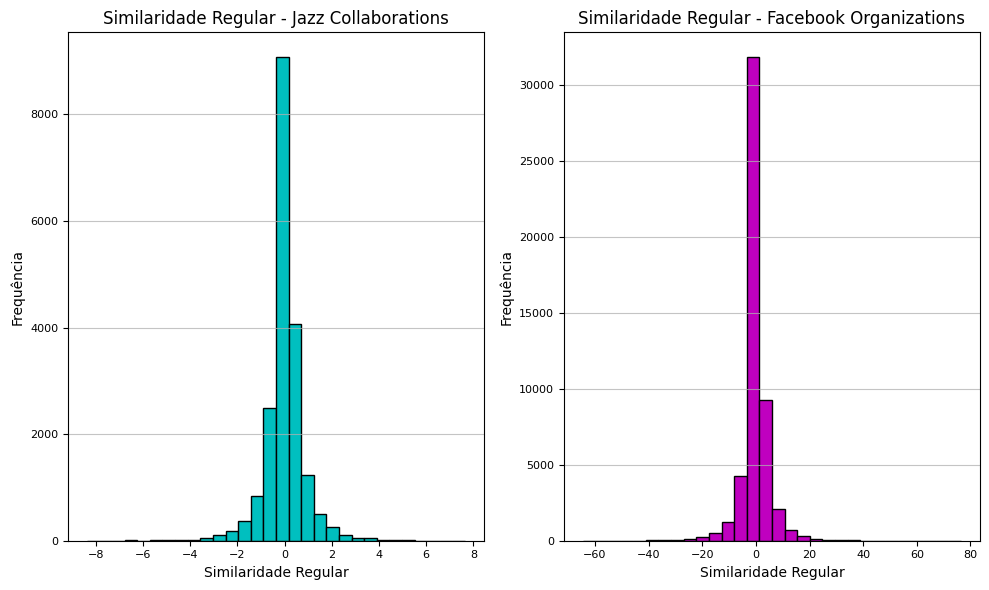

In [29]:
def calculate_regular_equivalence(G_nx):
    """
    Calcula a similaridade regular (equivalência) entre todos os pares de nós no grafo.

    Parâmetros:
    G_nx (networkx.Graph): O grafo para o qual calcular a similaridade.

    Retorna:
    list: Lista de similaridades regulares para todos os pares de vértices.
    """
    # Obter a matriz de adjacência do grafo
    adjacency_matrix = nx.to_numpy_array(G_nx)

    # Calcular a similaridade regular
    eye_matrix = np.eye(adjacency_matrix.shape[0])
    similarity_matrix = np.linalg.inv(eye_matrix - adjacency_matrix) - eye_matrix

    # Extrair os valores de similaridade em um formato adequado, ignorando a diagonal
    similarities = []
    for i in range(similarity_matrix.shape[0]):
        for j in range(i + 1, similarity_matrix.shape[1]):
            similarities.append(similarity_matrix[i][j])

    return similarities

# Calcular a similaridade regular para os grafos
similarities_jazz = calculate_regular_equivalence(G_jazz)
similarities_facebook = calculate_regular_equivalence(G_facebook)

# Criar uma figura com subplots 1x2
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

# Plotar o histograma das similaridades regulares para G_jazz
axes[0].hist(similarities_jazz, bins=30, color='c', edgecolor='black')
axes[0].set_title('Similaridade Regular - Jazz Collaborations', fontsize=12)
axes[0].set_xlabel('Similaridade Regular', fontsize=10)
axes[0].set_ylabel('Frequência', fontsize=10)
axes[0].tick_params(axis='both', which='major', labelsize=8)
axes[0].grid(axis='y', alpha=0.75)

# Plotar o histograma das similaridades regulares para G_facebook
axes[1].hist(similarities_facebook, bins=30, color='m', edgecolor='black')
axes[1].set_title('Similaridade Regular - Facebook Organizations', fontsize=12)
axes[1].set_xlabel('Similaridade Regular', fontsize=10)
axes[1].set_ylabel('Frequência', fontsize=10)
axes[1].tick_params(axis='both', which='major', labelsize=8)
axes[1].grid(axis='y', alpha=0.75)

# Ajustar espaçamento entre os subplots
plt.tight_layout()
plt.show()


### Explicação:
1. **Cálculo da Similaridade Regular**:
   - A matriz de adjacência é obtida e a similaridade regular é calculada com a fórmula $$S = (I - A)^{-1} - I,$$
onde $I$ é a matriz identidade e  $A$ é a matriz de adjacência.
   - Os valores são extraídos ignorando a diagonal da matriz de similaridade, que representa a similaridade de um nó consigo mesmo.

2. **Visualização**:
   - Histogramas para as distribuições de similaridade regular entre os pares de nós são plotados lado a lado para ambas as redes.



### Discussão das Diferenças Entre os Histogramas

#### 1. **Natureza das Medidas de Similaridade**:
   - **Similaridade de Coseno**: Esta medida reflete a orientação dos vetores que representam os nós no espaço de características. Ela é sensível à quantidade de conexões e a estrutura local ao redor dos nós, considerando apenas a interseção de vizinhos. Como resultado, a similaridade de coseno pode ter uma distribuição mais concentrada em torno de um intervalo específico, especialmente em redes densas, onde muitos nós compartilham múltiplos vizinhos.
   
   - **Similaridade Regular (Equivalência Regular)**: Esta medida, por outro lado, leva em conta a conectividade global, permitindo que caminhos de diferentes comprimentos contribuam para a similaridade entre nós. Isso significa que ela captura uma noção mais abrangente de "equivalência" ao considerar não apenas vizinhos imediatos, mas também como os nós estão conectados em caminhos mais longos. Isso pode resultar em uma distribuição mais dispersa, refletindo as múltiplas maneiras pelas quais os nós podem ser similares, mesmo que não compartilhem muitos vizinhos diretos.

#### 2. **Formato das Distribuições**:
   - **Histograma da Similaridade de Coseno**: Pode apresentar picos distintos, refletindo a presença de grupos de nós que estão fortemente conectados. Os valores de similaridade podem estar concentrados em torno de um valor médio, mostrando que muitos nós têm características semelhantes dentro de uma comunidade específica.
   
   - **Histograma da Similaridade Regular**: Este pode mostrar uma distribuição mais uniforme ou dispersa, dependendo da estrutura da rede. Em redes mais esparsas, a distribuição pode ser mais ampla, refletindo a variabilidade na conectividade. Em redes densas, pode haver um aumento na similaridade, mas a forma do histograma pode não ser tão concentrada quanto a da similaridade de coseno.

#### 3. **Implicações Estruturais**:
   - **Redes Densas**: Em redes densas, a similaridade de coseno pode resultar em uma distribuição mais alta de valores próximos a 1, enquanto a similaridade regular pode revelar diferentes clusters de nós que não são imediatamente visíveis através de vizinhos compartilhados. Isso sugere que a estrutura da rede é complexa e que as relações vão além das conexões diretas.

   - **Redes Esparsas**: Para redes esparsas, a similaridade de coseno pode resultar em muitos valores baixos, enquanto a similaridade regular pode ainda captar algum nível de conexão entre nós através de caminhos mais longos, levando a uma distribuição que mostra mais variação.

### Conclusão:
A comparação das distribuições de similaridade entre as duas medidas destaca a importância de considerar o contexto e a estrutura da rede ao analisar similaridades entre nós. A similaridade de coseno pode ser mais eficaz em capturar relações locais imediatas, enquanto a similaridade regular oferece uma perspectiva mais abrangente sobre a conectividade global. Essas diferenças podem ajudar a compreender melhor as dinâmicas subjacentes da rede e a identificar padrões que podem não ser evidentes através de uma única medida de similaridade.





**Exercício 4.** Um método popular de cálculo de similaridade consiste na utilização do conceito de word embeddings (sequências de símbolos) para calcular a similaridade entre vértices. Descreva
sucintamente como o método node2vec trabalha. Para consulta: https://en.wikipedia.org/wiki/Node2vec.

O método node2vec é fundamentado em conceitos matemáticos que se relacionam com a teoria dos grafos e o aprendizado de representações. A seguir, apresento um resumo dos principais conceitos matemáticos envolvidos no node2vec, incluindo algumas demonstrações simplificadas.

1. Caminhadas Aleatórias em Grafos  
As caminhadas aleatórias são fundamentais para o node2vec. Uma caminhada aleatória em um grafo é um processo estocástico onde, em cada passo, o agente se move de um nó $_t$ para um nó $v_{t+1}$, selecionando um vizinho de $v_t$ de forma aleatória.

   Definição  
   Seja $G = (V, E$ um grafo, onde $V$ é o conjunto de vértices e $E$ é o conjunto de arestas. Uma caminhada aleatória a partir de um nó $v$ é definida como:

   $$
   v_{t+1} \sim \text{Uniform}(N(v_t))
   $$

   onde $N(v_t)$ é o conjunto de vizinhos de $v_t$.

2. Parâmetros de Exploração $p$ e $q$  
Os parâmetros $p$ e $q$ controlam a exploração durante a caminhada aleatória.

   - $p$: controla a probabilidade de retornar ao nó anterior. Um valor baixo de $p$ resulta em uma tendência a voltar ao nó anterior, enquanto um valor alto de $p$ favorece a exploração de novos vizinhos.
   - $q$: controla a probabilidade de explorar vizinhos mais distantes. Um valor baixo de $q$ incentiva a exploração de vizinhos diretos, enquanto um valor alto de $q$ permite uma maior exploração em profundidade.

   Transição de Caminhadas  
   A probabilidade de mover de um nó $v$ para um nó $u$ depende de $p$ e $q$ e é dada pela seguinte equação:

   $$
   P(v \to u) =
   \begin{cases}
   \frac{1}{p} & \text{se } u \text{ é o nó anterior} \\
   1 & \text{se } u \text{ é um vizinho direto} \\
   \frac{1}{q} & \text{se } u \text{ é um vizinho de segundo grau}
   \end{cases}
   $$

3. Geração de Sequências de Nós  
As caminhadas geradas são tratadas como sequências de nós, assim como palavras em um texto. A sequência de nós $$S = (v_1, v_2, \ldots, v_t)$$ é gerada por meio de múltiplas caminhadas aleatórias.

4. Modelo de Aprendizado  
Node2vec utiliza um modelo de aprendizado (como Skip-Gram) para mapear nós para um espaço vetorial. A função objetivo do modelo é maximizar a probabilidade de prever um nó central $v_i$ com base em seus vizinhos $v_j$:

$$
\max \prod_{(v_i, v_j) \in S} P(v_j | v_i)
$$

Onde $P(v_j | v_i)$ é a probabilidade condicional de um nó $v_j$ dado um nó central $v_i$.

5. Softmax e Representações Vetoriais  
Para calcular a probabilidade $P(v_j | v_i)$, é comum usar a função softmax:

$$
P(v_j | v_i) = \frac{e^{u_j \cdot u_i}}{\sum_{k \in V} e^{u_k \cdot u_i}}
$$

Onde $u_i$ e $u_j$ são os vetores de representação dos nós $v_i$ e $v_j$.

6. Treinamento do Modelo  
O modelo é treinado através de técnicas de otimização, como Stochastic Gradient Descent (SGD), para ajustar os vetores de características dos nós.

**Resumo**  
O node2vec combina caminhadas aleatórias controladas com aprendizado de representações para mapear nós em um espaço vetorial. Isso permite calcular similaridades entre nós com base na estrutura do grafo. O ajuste dos parâmetros de exploração $p$ e $q$ proporciona flexibilidade, permitindo que o método capture tanto a conectividade local quanto a global da rede.

Esses conceitos matemáticos formam a base para a implementação do node2vec e a aplicação de embeddings em várias tarefas de aprendizado de máquina.




**Exercício 5.** Assim como no método node2vec, caminhadas aleatórias também podem ser usadas para calcular a similaridade entre vértices. O conceito de primeiro tempo de passagem (MFPT) do vértice $i$ ao vértice $j$ corresponde ao número de passos que um agente caminhando de maneira aleatória na rede leva para atingir $j$ a partir de $i$ pela primeira vez. Veja por exemplo: https://en.wikipedia.org/wiki/Random_walk_closeness_centrality.

Selecione alguns pares de vértices de sua rede e calcule o MFPT entre eles via simulação.
Verifique se $MFPT(i,j) = MFPT(j,i)$.

In [31]:
def calculate_mfpt(G, pairs, num_walks=1000, walk_length=10):
    """
    Calcula o tempo médio de primeiro retorno (MFPT) entre pares de vértices usando caminhadas aleatórias.

    Parâmetros:
    G (networkx.Graph): O grafo para o qual calcular o MFPT.
    pairs (list): Lista de tuplas contendo pares de vértices.
    num_walks (int): Número de caminhadas aleatórias a serem realizadas.
    walk_length (int): Comprimento de cada caminhada aleatória.

    Retorna:
    dict: Dicionário com o MFPT para cada par de vértices.
    """
    mfpt_results = {}

    for u, v in pairs:
        for pair in [(u, v), (v, u)]:  # Calcular para ambos os sentidos
            mfpt_sum = 0
            for _ in range(num_walks):
                current = pair[0]
                steps = 0
                while current != pair[1] and steps < walk_length:
                    current = random.choice(list(G.neighbors(current)))
                    steps += 1

                if current == pair[1]:
                    mfpt_sum += steps

            if mfpt_sum > 0:
                mfpt_results[pair] = mfpt_sum / num_walks

    return mfpt_results

# Selecionar alguns pares de vértices para calcular o MFPT
pairs_jazz = [(0, 1), (2, 3), (4, 5)]  # Substitua pelos índices ou rótulos reais dos nós em G_jazz
pairs_facebook = [(0, 1), (2, 3), (4, 5)]  # Substitua pelos índices ou rótulos reais dos nós em G_facebook

# Calcular o MFPT para as redes
mfpt_jazz = calculate_mfpt(G_jazz, pairs_jazz)
mfpt_facebook = calculate_mfpt(G_facebook, pairs_facebook)

print("MFPT para G_jazz:", mfpt_jazz)
print("MFPT para G_facebook:", mfpt_facebook)

# Verificar se MFPT(i, j) = MFPT(j, i)
for (u, v), mfpt_value in mfpt_jazz.items():
    print(f"MFPT({u}, {v}) = {mfpt_value}, MFPT({v}, {u}) = {mfpt_jazz.get((v, u), 'Não calculado')}")

for (u, v), mfpt_value in mfpt_facebook.items():
    print(f"MFPT({u}, {v}) = {mfpt_value}, MFPT({v}, {u}) = {mfpt_facebook.get((v, u), 'Não calculado')}")


MFPT para G_jazz: {(0, 1): 0.287, (1, 0): 0.29, (2, 3): 0.533, (3, 2): 0.366, (4, 5): 0.409, (5, 4): 0.235}
MFPT para G_facebook: {(0, 1): 0.274, (1, 0): 0.376, (2, 3): 0.318, (3, 2): 0.709, (4, 5): 0.749, (5, 4): 0.07}
MFPT(0, 1) = 0.287, MFPT(1, 0) = 0.29
MFPT(1, 0) = 0.29, MFPT(0, 1) = 0.287
MFPT(2, 3) = 0.533, MFPT(3, 2) = 0.366
MFPT(3, 2) = 0.366, MFPT(2, 3) = 0.533
MFPT(4, 5) = 0.409, MFPT(5, 4) = 0.235
MFPT(5, 4) = 0.235, MFPT(4, 5) = 0.409
MFPT(0, 1) = 0.274, MFPT(1, 0) = 0.376
MFPT(1, 0) = 0.376, MFPT(0, 1) = 0.274
MFPT(2, 3) = 0.318, MFPT(3, 2) = 0.709
MFPT(3, 2) = 0.709, MFPT(2, 3) = 0.318
MFPT(4, 5) = 0.749, MFPT(5, 4) = 0.07
MFPT(5, 4) = 0.07, MFPT(4, 5) = 0.749
